# Goodreads Book Reviews

In [1]:
#change display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Loading Data

In [3]:
#importing packages
import tqdm
import re
import gzip
import json
import re
import os
import sys
import numpy as np
import pandas as pd
import pickle

In [6]:
#set directory for loading dataset
DIR = './goodreads-master/'

In [7]:
#function to preview or read in the data the data
#takes each line to a list and then appends to a list to make a list of lists
def load_data(file_name, head = 500):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            data_list = []
            data_list.append(d['user_id'])
            data_list.append(d['book_id'])
            data_list.append(d['review_id'])
            data_list.append(d['rating'])
            data_list.append(d['review_text'])
            if r'(view spoiler)' in d['review_text']:
                data_list.append(1)
            else: data_list.append(0)
            data.append(data_list)
            count += 1
            
            # break if reaches the 100th line
            if (head is not None) and (count > head):
                break
    return data

In [8]:
#load in raw text (this will probably a little while)
data = load_data(os.path.join(DIR, 'goodreads_reviews_spoiler_raw.json.gz'), head = None)

In [9]:
#take the list of lists to DF

df = pd.DataFrame(data, columns = ['user_id', 'book_id', 'review_id', 'rating', 'review_text', 'spoiler'])
print(df.review_id.nunique())

df.set_index('review_id', inplace = True)
print('')
df.info()


1378033

<class 'pandas.core.frame.DataFrame'>
Index: 1378033 entries, dfdbb7b0eb5a7e4c26d59a937e2e5feb to 62ed1263c7d216986cc419cd4e8a408b
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   user_id      1378033 non-null  object
 1   book_id      1378033 non-null  object
 2   rating       1378033 non-null  int64 
 3   review_text  1378033 non-null  object
 4   spoiler      1378033 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 63.1+ MB


In [10]:
#remove data from memory
del(data)

## Early Data Exploration

In [30]:
df.rating.value_counts()

4    480199
5    403374
3    290430
2    112226
0     47052
1     44752
Name: rating, dtype: int64

I was not expecting the 0 score for reviews. Let's take a look.

**Not necessary to rerun**

In [31]:
#list of 0 scored reviews
review_text0 = [df.review_text.iloc[i] for i in range(len(df.review_text)) if df.rating.iloc[i] == 0]

In [32]:
#random sample to examine data
np.random.choice(review_text0)

"I was on the fence about this trilogy when I started Steelheart, but by the time I read Calamity my emotions were a mess and David really came to grow on me. Calamity starts off shortly after Firefight ended with Prof leaving the Reckoners and fallen to his powers. David, now leading the Reckoners and rejoined by Cody and Abraham who were absent in Firefight, has a plan to get Prof to face his weakness and return to the man they once knew. \n The book is ambitious, taking place in another city called Ildithia. What it reminds me of is something like Howl's Moving Castle, but instead of a castle, it's an entire city that moves and rebuilds itself as it travels across North America. We slowly start to see what Regalia's plans were and why Prof deciding settle in this particular city was fundamental to her plans. \n Calamity is unforgiving. There's no path out of darkness without sacrifice, and the sacrifice in this book was a gut-wrenching one. On a lighter note, there are spy missions 

Reviews with 0 stars often appear to be from people who did not finish the book or were in the process of reading. However, they can also be legitimate reviews. They are sometimes negative or positive, but are most often neutral. Goodreads allows you to review without setting the stars, so these reviews should likely be thrown out for prediction purposes.

In [33]:
#remove from memory
del(review_text0)

## Data Cleaning

In [11]:
#removing the 0 ratings
df = df.loc[df.rating != 0]
len(df)

1330981

In [12]:
#remove those reviews of under 100 characters for computational speed purposes
df = df.loc[(df.review_text.astype(str).str.len()) >= 100]
len(df)

1175005

In [13]:
#number of unique users
df.user_id.nunique()

18833

In [14]:
#number of unique books
df.book_id.nunique()

25466

In [15]:
#mapping the 5 starts to negative, neutral, positive
df.rating = df.rating.map({1 : -1, 2 : -1, 3 : 0, 4 : 1, 5: 1})
df.rating.value_counts()

 1    771529
 0    261806
-1    141670
Name: rating, dtype: int64

In [16]:
#down sampling the largest class to make it the sum of the size of the other classes; doing this to help simpler models and to help with hardware constraints
df1 = df.loc[df.rating == 1].sample(n = 403476, random_state = 87, axis = 0)
len(df1)

403476

In [17]:
#append the downsampled positive reviews to the new dataframe
df = df.loc[df.rating != 1].append(df1)
len(df)

806952

In [18]:
#removing other df from memory
del(df1)

In [42]:
#building out a normalization dict to perform prior to stemming
normalization_dict = {'was' : 'be', 'is' : 'be', 'are': 'be', 'been': 'be', 'were': 'be', 'am' : 'be', 
                      'wasnt':'isnt', 'arent':'isnt', 'werent':'isnt', 'does': 'do', 'has': 'have', 'had' : 'have',
                      'so':'', 'such':'', 'the':'', 'a':'', 'an':'', 'to': '', 'of':'', 'in':'', 'on':'', 'all':'', 
                      'for':'', 'about':'', 'at':'', 'that':'', 'this':'', 'probably':'', 'just':'', 'as':'',
                      '1':'one', '2':'two', '3':'three', '4':'four', '5':'five', '6':'six', '7':'seven', '8':'eight', '9':'nine', #numbers 
                      'he':'_pron_', 'she':'_pron_', 'i':'_pron_', 'we':'_pron_', 'you':'_pron_', 'it':'_pron_', 'they':'_pron_', #personal subject pronouns
                      'me':'_pron_', 'us':'_pron_', 'her':'_pron_', 'him':'_pron_', 'them':'_pron_', 'his':'_pron_'} #obj pronouns

In [43]:
#writing a preprocessing and normalization function

from nltk.stem import PorterStemmer
 
# init stemmer
porter_stemmer=PorterStemmer()
 
def basic_preprocessor(text):
    text = re.sub(r"(view spoiler)|(hide spoiler)|\n", "", text) #removing view spoiler, hide spoiler and newline char
    
    text=text.lower() #lower case text
    
    text = re.sub("[^a-z0-9 ]+", "", text) #remove everything except letters and numbers, and spaces (can replace with blank)
    
    #split out words for our list comprehension
    words=re.split("\\s+",text)
    
    #use the normalization words
    normalization_words = [normalization_dict[word] if word in normalization_dict.keys() else word for word in words]
    
    # stem words that aren't blank
    stemmed_words=[porter_stemmer.stem(word=word) for word in normalization_words if word != ""]
        
    return ' '.join(stemmed_words)

**Be careful of processing time below. DO NOT RERUN**

In [24]:
#preprocessing text
df.review_text = [basic_preprocessor(text) for text in df.review_text]

In [45]:
#checking preprocessing
df.review_text[0]

'fun fast pace scienc fiction thriller _pron_ read _pron_ two night and couldnt put _pron_ down book be quantum theori mani world which state decis _pron_ make throughout our live basic creat branch and each possibl path through decis tree can be thought parallel world and book someon invent way switch between these world be nice allud toforeshadow quot _pron_ think choic weve made creat moment _pron_ sit here togeth beauti tabl then _pron_ think possibl event could have stop moment from ever happen and _pron_ feel _pron_ dont know what fragil now _pron_ becom thought moment _pron_ say final it terrifi when _pron_ consid everi thought _pron_ have everi choic _pron_ could possibl make branch into new world book cant be discuss without spoiler _pron_ be book choic and regret ever regret not chase girl your dream _pron_ can focu your career well jason2 made choic and then did regret _pron_ clearli author be tri tell _pron_ optim happi be second rate physic teacher commun colleg if _pron_ 

In [30]:
#pickling the preprocessed text
with open("preprocessed_text.txt", "wb") as fp:   #Pickling
    pickle.dump(list(df.review_text), fp)

In [19]:
#unpickle the preprocessed text list (loading from file)
with open("preprocessed_text.txt", "rb") as fp:   # Unpickling
    df.review_text = pickle.load(fp)

## Splitting Data Prior to Feature Creation/Engineering

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['rating', 'user_id', 'book_id'], axis = 1), 
                                                    df.rating, test_size=0.20, random_state = 43)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(645561, 2) (645561,)
(161391, 2) (161391,)


In [21]:
#remove df from memory
del(df)

In [48]:
#Count Vectorizer or tfidf_vectorizer?
#I use 20% because only using bigrams due to memory constraints (would use 25 - 30% if included 1-grams)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, use_idf=True, max_df = 0.20, min_df = 400, ngram_range = (2,2),
                                  lowercase = False)

In [49]:
tfidf_vectors_train = tfidf_vectorizer.fit_transform(X_train.review_text)

In [50]:
#pickling the results
with open("tfidf_vectors_train.pkl", "wb") as fp:   #Pickling
    pickle.dump(tfidf_vectors_train, fp)

In [22]:
#unpickle the results
with open("tfidf_vectors_train.pkl", "rb") as fp:   # Unpickling
    tfidf_vectors_train = pickle.load(fp)

In [51]:
tfidf_vectors_test = tfidf_vectorizer.transform(X_test.review_text)

In [52]:
#pickling the results
with open("tfidf_vectors_test.pkl", "wb") as fp:   #Pickling
    pickle.dump(tfidf_vectors_test, fp)

In [23]:
#unpickle the results
with open("tfidf_vectors_test.pkl", "rb") as fp:   # Unpickling
    tfidf_vectors_test = pickle.load(fp)

In [53]:
len(tfidf_vectorizer.vocabulary_)

26519

In [54]:
tfidf_vectors_train.shape

(645561, 26519)

In [55]:
#checking if some expected words are in our vocab to deterime if 20% is an OK cutoff for frequency
tfidf_vectorizer.vocabulary_['isnt _pron_']

13640

In [58]:
# print idf values
df_idf = pd.DataFrame(tfidf_vectorizer.idf_, index=tfidf_vectorizer.get_feature_names(),columns=["idf_weights"])
 
# sort ascending
df_idf.sort_values(by=['idf_weights']).iloc[:15]

,idf_weights
with _pron_,2.619733
read _pron_,2.640512
have be,2.666133
_pron_ want,2.685617
what _pron_,2.724946
_pron_ can,2.746519
_pron_ did,2.778425
be not,2.786399
_pron_ isnt,2.891110
_pron_ read,2.921257


In [59]:
feature_names = tfidf_vectorizer.get_feature_names()
 
#get tfidf vector for first document
first_document_vector=tfidf_vectors_train[0]
 
#print the scores
df1 = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df1.sort_values(by=["tfidf"],ascending=False).head(15)

,tfidf
do take,0.240233
sure who,0.236756
and experi,0.215652
book ill,0.212925
take time,0.212241
or do,0.209944
doesnt matter,0.208473
_pron_ anyon,0.200951
age _pron_,0.198602
either way,0.193778


In [34]:
del(df1)

## Reducing Dimensionality

In [77]:
#using truncated SVD to reduce dimensionality further
#truncated SVD can take sparse matricies which is important due to memory constraints
from sklearn.decomposition import TruncatedSVD

#sklearn recommends 100 components for LSA
svd = TruncatedSVD(n_components=300, n_iter=10, random_state=87)

**Be careful of calc time**

In [78]:
SVD_train = svd.fit_transform(X = tfidf_vectors_train, y = y_train)

In [79]:
#pickling the results
with open("SVD_train.pkl", "wb") as fp:   #Pickling
    pickle.dump(SVD_train, fp)

In [ ]:
#unpickle the results
with open("SVD_train.pkl", "rb") as fp:   # Unpickling
    SVD_train = pickle.load(fp)

In [80]:
SVD_test = svd.transform(X = tfidf_vectors_test)

In [81]:
#pickling the results
with open("SVD_test.pkl", "wb") as fp:   #Pickling
    pickle.dump(SVD_test, fp)

In [ ]:
#unpickle the results
with open("SVD_test.pkl", "rb") as fp:   # Unpickling
    SVD_test = pickle.load(fp)

In [82]:
type(SVD_train)

numpy.ndarray

In [83]:
SVD_train.shape

(645561, 300)

In [84]:
#keeping memory cleared out
del(X_train, X_test, tfidf_vectors_train, tfidf_vectors_test)

## Modeling Sentiment

### Logistic Regression

#### Baseline Sentiment Prediction (tfidf_vectors only)

In [71]:
from sklearn.linear_model import LogisticRegression

tfidf_log_reg = LogisticRegression(verbose=1, solver='lbfgs', random_state=45, C=1, penalty='l2', max_iter=500, n_jobs = -1)

In [72]:
#only using tfidf features
model = tfidf_log_reg.fit(tfidf_vectors_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  6.4min finished


In [73]:
from sklearn.metrics import accuracy_score, f1_score, log_loss
# Actual class predictions
base_preds = model.predict(tfidf_vectors_test)
# Probabilities for each class
base_probs = model.predict_proba(tfidf_vectors_test)[:,]

base_accuracy_score = accuracy_score(y_test, base_preds)
base_f1_value = f1_score(y_test, base_preds, average ='weighted')
base_log_loss_value = log_loss(y_test, base_probs, normalize=True)
print("Accuracy Score:     {:0.4f}".format(base_accuracy_score))
print("       F-score:     {:0.4f}".format(base_f1_value))
print("      Log Loss:     {:0.4f}".format(base_log_loss_value))

Accuracy Score:     0.7285
       F-score:     0.7245
      Log Loss:     0.6165


#### Tfidf Tuning

In [24]:
from sklearn.linear_model import LogisticRegressionCV
cv = LogisticRegressionCV(Cs=[0.0001, 0.001, .01, .1, 1, 10, 100, 1000], penalty='l2', solver='lbfgs', max_iter=500, cv = 4, 
                          n_jobs=4, verbose=1, random_state = 53)

In [25]:
tfidf_logit_model = cv.fit(tfidf_vectors_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed: 52.0min remaining: 52.0min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 53.1min finished


In [26]:
tfidf_logit_model.scores_

{-1: array([[0.50020137, 0.5030516 , 0.64968307, 0.72036235, 0.72574679,
         0.71678718, 0.71399892, 0.71357139],
        [0.50020447, 0.50312907, 0.64978623, 0.72093066, 0.72660636,
         0.71806803, 0.71500093, 0.71474689],
        [0.50019828, 0.50325299, 0.64982341, 0.72111655, 0.72681083,
         0.71757854, 0.71461677, 0.71427598],
        [0.50019828, 0.50346986, 0.65105645, 0.72326662, 0.72754198,
         0.71759093, 0.71457959, 0.71400335]]),
 0: array([[0.50020137, 0.5030516 , 0.64968307, 0.72036235, 0.72574679,
         0.71678718, 0.71399892, 0.71357139],
        [0.50020447, 0.50312907, 0.64978623, 0.72093066, 0.72660636,
         0.71806803, 0.71500093, 0.71474689],
        [0.50019828, 0.50325299, 0.64982341, 0.72111655, 0.72681083,
         0.71757854, 0.71461677, 0.71427598],
        [0.50019828, 0.50346986, 0.65105645, 0.72326662, 0.72754198,
         0.71759093, 0.71457959, 0.71400335]]),
 1: array([[0.50020137, 0.5030516 , 0.64968307, 0.72036235, 0.7257467

It appears as though C = 1 was already well tuned.

#### Baseline Sentiment Prediction (SVD features only)

In [102]:
#logistic regression model

from sklearn.linear_model import LogisticRegression

svd_log_reg = LogisticRegression(verbose=1, solver='lbfgs', random_state=45, C=1, penalty='l2', max_iter=500, n_jobs = -1)

In [ ]:
#only using SVD features
model = svd_log_reg.fit(SVD_train, y_train)

In [87]:
from sklearn.metrics import accuracy_score, f1_score, log_loss
# Actual class predictions
base_preds = model.predict(SVD_test)
# Probabilities for each class
base_probs = model.predict_proba(SVD_test)[:,]

base_accuracy_score = accuracy_score(y_test, base_preds)
base_f1_value = f1_score(y_test, base_preds, average ='weighted')
base_log_loss_value = log_loss(y_test, base_probs, normalize=True)
print("Accuracy Score:     {:0.4f}".format(base_accuracy_score))
print("       F-score:     {:0.4f}".format(base_f1_value))
print("      Log Loss:     {:0.4f}".format(base_log_loss_value))

Accuracy Score:     0.6914
       F-score:     0.6838
      Log Loss:     0.6914


In [88]:
del(model)

#### SVD Tuning

In [98]:
from sklearn.linear_model import LogisticRegressionCV
cv = LogisticRegressionCV(Cs=[0.0001, 0.001, .01, .1, 1, 10, 100, 1000], penalty='l2', solver='lbfgs', max_iter=500, cv = 4, 
                          n_jobs=4, verbose=1, random_state = 53)

In [91]:
svd_logit_model = cv.fit(SVD_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed: 29.1min remaining: 29.1min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 30.1min finished


In [92]:
svd_logit_model.scores_

{-1: array([[0.50020137, 0.50313214, 0.63190017, 0.68411498, 0.68830356,
         0.68867533, 0.68870011, 0.68867533],
        [0.50020447, 0.50327158, 0.63213954, 0.68464589, 0.68917529,
         0.68956565, 0.6896462 , 0.68966479],
        [0.50019828, 0.50344507, 0.63142078, 0.68384039, 0.68902658,
         0.68908235, 0.68911952, 0.68911333],
        [0.50019828, 0.50365574, 0.63377533, 0.68696326, 0.69221141,
         0.69230436, 0.69231675, 0.69232294]]),
 0: array([[0.50020137, 0.50313214, 0.63190017, 0.68411498, 0.68830356,
         0.68867533, 0.68870011, 0.68867533],
        [0.50020447, 0.50327158, 0.63213954, 0.68464589, 0.68917529,
         0.68956565, 0.6896462 , 0.68966479],
        [0.50019828, 0.50344507, 0.63142078, 0.68384039, 0.68902658,
         0.68908235, 0.68911952, 0.68911333],
        [0.50019828, 0.50365574, 0.63377533, 0.68696326, 0.69221141,
         0.69230436, 0.69231675, 0.69232294]]),
 1: array([[0.50020137, 0.50313214, 0.63190017, 0.68411498, 0.6883035

In [ ]:
#choose the best C
del(logit_model)

In [93]:
#best C was 1000
svd_log_reg = LogisticRegression(verbose=1, solver='lbfgs', random_state=53, C=1000, penalty='l2', max_iter=500, n_jobs = -1)
model = svd_log_reg.fit(SVD_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 30.6min finished


In [94]:
from sklearn.metrics import accuracy_score, f1_score, log_loss
# Actual class predictions
base_preds = model.predict(SVD_test)
# Probabilities for each class
base_probs = model.predict_proba(SVD_test)[:,]

base_accuracy_score = accuracy_score(y_test, base_preds)
base_f1_value = f1_score(y_test, base_preds, average ='weighted')
base_log_loss_value = log_loss(y_test, base_probs, normalize=True)
print("Accuracy Score:     {:0.4f}".format(base_accuracy_score))
print("       F-score:     {:0.4f}".format(base_f1_value))
print("      Log Loss:     {:0.4f}".format(base_log_loss_value))

Accuracy Score:     0.6917
       F-score:     0.6845
      Log Loss:     0.6908


In [95]:
#pickling the model
with open("logit_model.pkl", "wb") as fp:   #Pickling
    pickle.dump(model, fp)

In [ ]:
#unpickle the model (loading from file)
with open("logit_model.pkl", "rb") as fp:   # Unpickling
    model = pickle.load(fp)

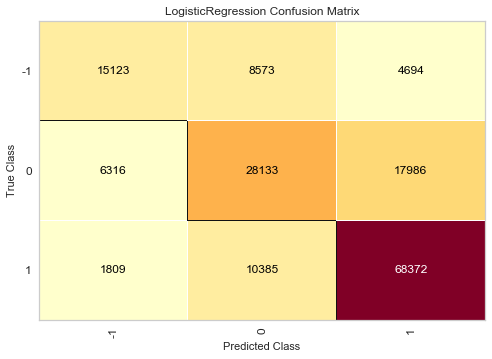

In [96]:
#logit confusion matrix
from yellowbrick.classifier import ConfusionMatrix

knn_cm = ConfusionMatrix(model)

knn_cm.fit(SVD_train, y_train)
knn_cm.score(SVD_test, y_test)

knn_cm.show()

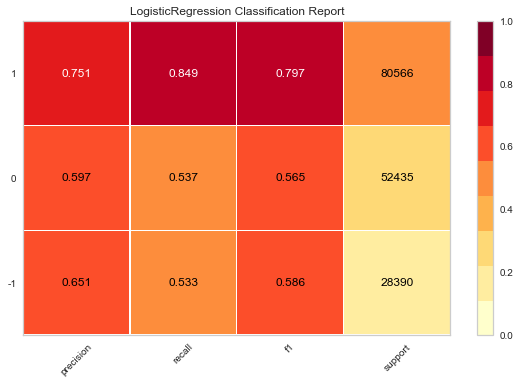

In [97]:
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(model, support=True)

visualizer.fit(SVD_train, y_train)        # Fit the visualizer and the model
visualizer.score(SVD_test, y_test)        # Evaluate the model on the test data
visualizer.show()



In [ ]:
#try out a more advanced model